# <center>Kemna-Vorst Variable</center>
##### <center><i>Hippolyte Giraud</i></center>


In [586]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

sq = np.random.SeedSequence()
rng = np.random.default_rng(sq)

In [587]:
import seaborn as sns
sns.reset_defaults()
sns.set(style='darkgrid', palette='colorblind')

In [588]:
def phi(tab, k):
    return np.maximum(tab-k, 0)

print(phi(np.array([1,2,3,4,5]), 3))

[0 0 0 1 2]


In [589]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    return np.array((mean, var, mean - ci_size, mean + ci_size))

In [590]:
def brownian1d(n_paths, n_timesteps, final_time=1):
    delta = final_time / n_timesteps
    dB = np.sqrt(delta) * rng.standard_normal((n_paths, n_timesteps))
    brownian = np.concatenate((np.zeros((n_paths, 1)), np.cumsum(dB, axis=1)), axis=1)
    return brownian

def simulation_asset(x, r, sigma, final_time, W):
    t = np.linspace(0, final_time, len(W[0]))
    asset = x * np.exp((r - sigma**2/2) * t + sigma * W)
    return asset

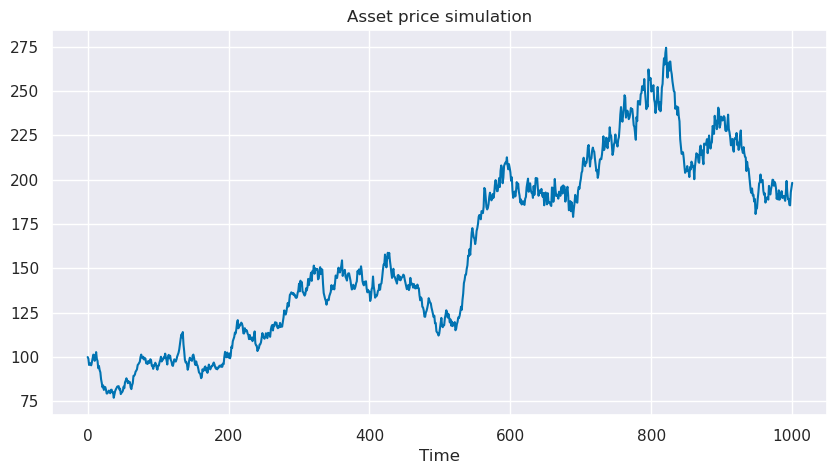

In [591]:
W = brownian1d(1000, 1000, 10)
asset = simulation_asset(100, 0.05, 0.2, 1, W)

plt.figure(figsize=(10, 5))
plt.plot(asset[0])
plt.title('Asset price simulation')
plt.xlabel('Time')
plt.show()

We are first interesting in applying a Monte Carlo method without any variance reduction method, in order to do that we need to be able to simulate:
$$ \frac{1}{T} \int_0^T X^x_T\, dx  $$


We will use the mid-point integration

In [592]:
def mid_int(assets, T):
    mid = (assets[:, 1:] + assets[:, :-1]) / 2
    step = T/len(mid[0])
    return step * np.sum(mid, axis=1)

def asian_option_simulation(x, r, sigma, T, K, W):
    assets = simulation_asset(x, r, sigma, T, W)
    integrals = (1/T)*mid_int(assets, T)
    prices = np.exp(-r*T)*phi(integrals, K)
    return monte_carlo(prices)

In [593]:
t = np.linspace(0, 1, 100)
x = t**2
print(mid_int(np.array([x,x]), 1))

[0.33335034 0.33335034]


Now let's use Monte Carlo method to find the price of the asian option

In [594]:
# parameters
x = 100
K = 110
max_T = 1
sigma = 0.4
r = 0.03

n_paths = 10000 #nb of paths
n_timesteps = 1000 #nb_of_timesteps for each path
n_mesures = 20 #mesurer la performence pour 20 T entre 0 et max_T
delta_steps = int(n_timesteps/n_mesures)  # nb of timesteps between each mesure
delta_t = max_T * (delta_steps/n_timesteps) # time between each mesure

times = [i*delta_t for i in range(1, n_mesures)]

In [595]:
W = brownian1d(n_paths, n_timesteps, max_T)
simulation_classic = [asian_option_simulation(x, r, sigma, i*delta_t, K, W[:, :(i*delta_steps)]) for i in range(1, n_mesures)]

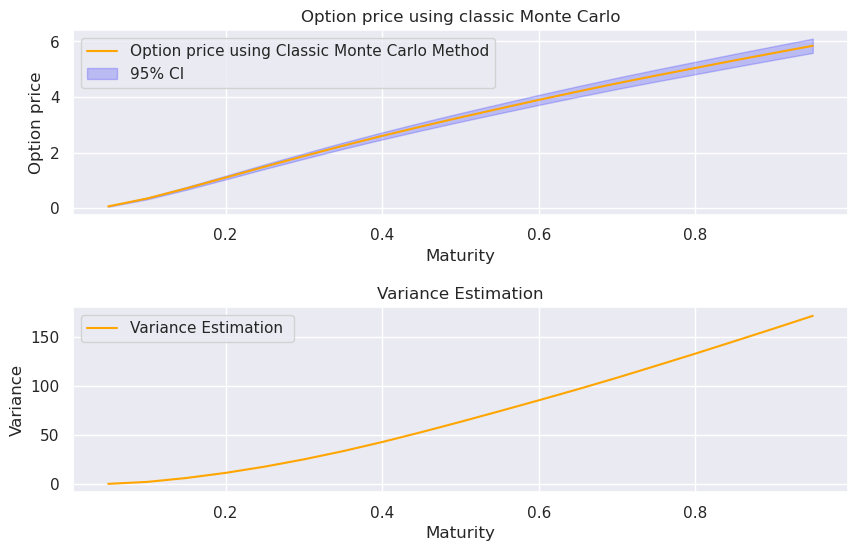

In [596]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(times, [i[0] for i in simulation_classic], label='Option price using Classic Monte Carlo Method', color='orange')
ax[0].fill_between(times, [i[2] for i in simulation_classic], [i[3] for i in simulation_classic], color='blue', alpha=0.2, label='95% CI')
# ax[0].plot(times, [i[2] for i in simulation_classic], label='95% CI', color='darkred', linestyle='--', alpha=0.7)
# ax[0].plot(times, [i[3] for i in simulation_classic], color='darkred', linestyle='--', alpha=0.7)
ax[0].set_title('Option price using classic Monte Carlo')
ax[0].legend()
ax[0].set_xlabel('Maturity')
ax[0].set_ylabel('Option price')

ax[1].plot(times, [i[1] for i in simulation_classic], label='Variance Estimation ', color='orange')
ax[1].set_title('Variance Estimation')
ax[1].legend()
ax[1].set_xlabel('Maturity')
ax[1].set_ylabel('Variance') 

plt.subplots_adjust(hspace=0.5)
plt.show()

Implémentation de la variable de Kemma-Vorst:
$$ k_T^{KV} = \phi(xe^{-(\frac{r}{2} + \frac{\sigma^2}{12})T}exp((r-\frac{1}{2}\frac{\sigma^2}{3})T + \sigma\frac{1}{T} \int_0^T W_t \,dt) ) $$ 

On a bien une formule fermée puisque :

$$\frac{1}{T} \int_0^T W_t \,dt \sim \mathcal{N}(0, \frac{T}{3})$$

Donc : 

$$ E(e^{-rT}k_T^{KV}) = Call_0^{BS}(S_0=xe^{-(\frac{r}{2} + \frac{\sigma^2}{12})T}, r, \frac{\sigma}{\sqrt{3}}, T, K)$$

Nous allons donc générer des samples $ (h_T, k_T^{KV})$ et appliquer la méthode de Monte Carlo à cette quantité:
$$ E(e^{-rT}*(h_T - k_T^{KV}))$$

On a bien le prix de l'option asiatique P donné par :

$$ P = E(e^{-rT}*(h_T - k_T^{KV})) + Call_0^{BS}(S_0=xe^{-(\frac{r}{2} + \frac{\sigma^2}{12})T}, r, \frac{\sigma}{\sqrt{3}}, T, K)$$

In [597]:
def call(x, r, sigma, T, K):
    d1 = (1/(sigma*np.sqrt(T)))*np.log((x*np.exp(r*T)/K)) + 0.5 * sigma * np.sqrt(T)
    d2 = d1 - sigma * np.sqrt(T)
    return x*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def simulation_kv(x, r, sigma, T, K, W):
    a = x*np.exp(-(0.5*r + ((sigma**2)/12))*T)
    int_W = mid_int(W, T)
    pre_kt = a*np.exp((r-((sigma**2)/6))*T + (sigma/T) * int_W)
    kt = phi(pre_kt, K) 
    return monte_carlo(np.exp(-r*T)*kt)
    

def asian_option_simulation_kv(x, r, sigma, T, K, W):
    times = np.linspace(0, T, len(W[0]))
    
    # preparation for kt
    a = x*np.exp(-(0.5*r + ((sigma**2)/12))*T)
    sigma_kt = sigma/np.sqrt(3)
    int_W = mid_int(W, T)
    pre_kt = a*np.exp((r-0.5*((sigma**2)/3))*T + (sigma/T)* int_W)

    pre_ht = (1/T) * mid_int(x*np.exp((r-0.5*(sigma**2)) * times + sigma * W), T)

    kt = phi(pre_kt, K)
    ht = phi(pre_ht, K)

    tab = np.exp(-r*T) * (ht - kt) + call(a, r, sigma_kt, T, K)

    return monte_carlo(tab)

In [598]:
# parameters
x = 100
K = 110
max_T = 1
sigma = 0.4
r = 0.03

n_paths = 10000 #nb of paths
n_timesteps = 1000 #nb_of_timesteps for each path
n_mesures = 100 #mesurer la performence pour 20 T entre 0 et max_T
delta_steps = int(n_timesteps/n_mesures)  # nb of timesteps between each mesure
detla_t = max_T * (delta_steps/n_timesteps) # time between each mesure

times = [i*detla_t for i in range(1, n_mesures)]


In [599]:
W = brownian1d(n_paths, n_timesteps, max_T)
simulation_kv = [asian_option_simulation_kv(x, r, sigma, i*delta_t, K, W[:, :(i*delta_steps)]) for i in range(1, n_mesures)]
simulation_classic = [asian_option_simulation(x, r, sigma, i*delta_t, K, W[:, :(i*delta_steps)]) for i in range(1, n_mesures)]

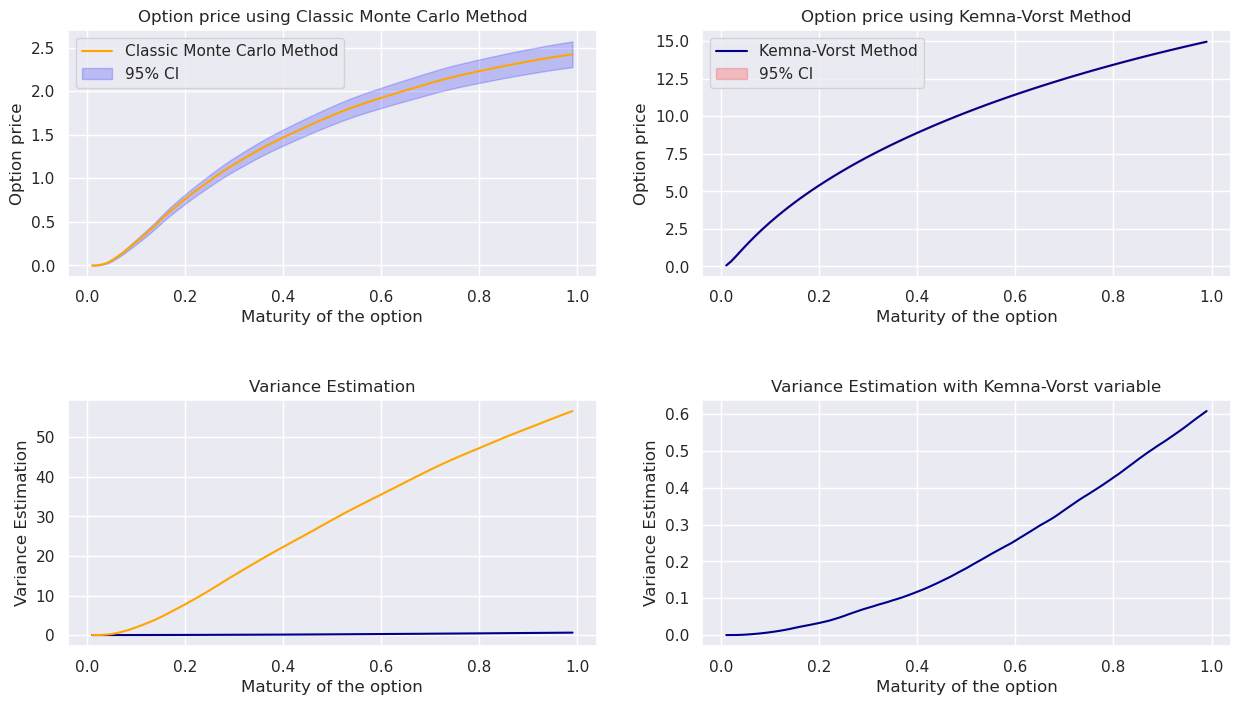

In [600]:
# plot the results 

fig, ax = plt.subplots(2,2, figsize=(15, 8))

ax[0][0].plot(times, [i[0] for i in simulation_classic], label='Classic Monte Carlo Method', color='orange')
ax[0][0].fill_between(times, [i[2] for i in simulation_classic], [i[3] for i in simulation_classic], color='blue', alpha=0.2, label='95% CI')
ax[0][0].set_title('Option price using Classic Monte Carlo Method')
ax[0][0].legend()
ax[0][0].set_xlabel('Maturity of the option')
ax[0][0].set_ylabel('Option price')



ax[0][1].plot(times, [i[0] for i in simulation_kv], label='Kemna-Vorst Method', color='darkblue')
ax[0][1].fill_between(times, [i[2] for i in simulation_kv], [i[3] for i in simulation_kv], color='red', alpha=0.2, label='95% CI')
ax[0][1].set_title('Option price using Kemna-Vorst Method')
ax[0][1].legend()
ax[0][1].set_xlabel('Maturity of the option')
ax[0][1].set_ylabel('Option price')



ax[1][0].plot(times, [i[1] for i in simulation_kv], label='Kemna-Vorst Variance', color='darkblue')
ax[1][0].plot(times, [i[1] for i in simulation_classic], label='Classical Variance', color='orange')
ax[1][0].set_title('Variance Estimation')
ax[1][0].set_xlabel('Maturity of the option')
ax[1][0].set_ylabel('Variance Estimation')

ax[1][1].plot(times, [i[1] for i in simulation_kv], label='Kemna-Vorst Variance', color='darkblue')
ax[1][1].set_title('Variance Estimation with Kemna-Vorst variable')
ax[1][1].set_xlabel('Maturity of the option')
ax[1][1].set_ylabel('Variance Estimation')

plt.subplots_adjust(hspace=0.5)

plt.show()

Traçons le rapport de variance pour que cela soit plus interprétable (on ne prend pas les premiers points à cause des erreurs de calcul proche de zero)

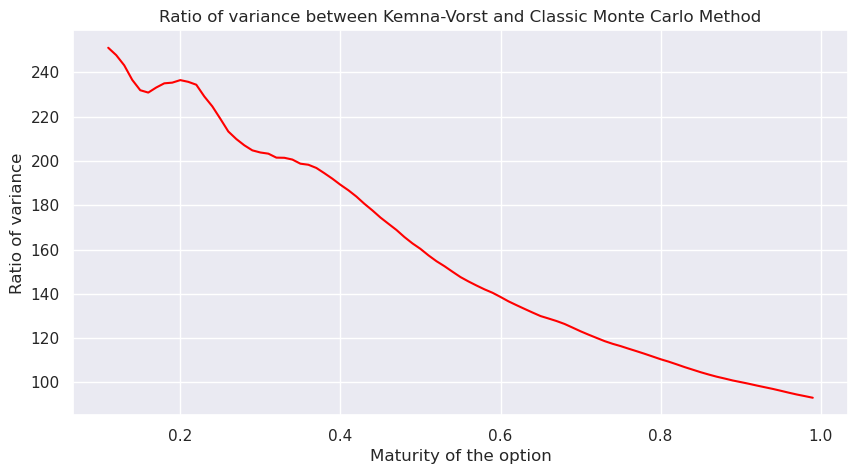

In [601]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(times[10:], [i[1]/v[1] for i, v in zip(simulation_classic[10:], simulation_kv[10:])], color='red')
ax.set_title('Ratio of variance between Kemna-Vorst and Classic Monte Carlo Method')
ax.set_xlabel('Maturity of the option')
ax.set_ylabel('Ratio of variance')

plt.show()

### Conclusion : La méthode de calcul avec la variable de Kemna-Vorst est considérablement plus efficace